# <center>**A Quick Introduction to Generative Adversarial Networks (GAN)**</center>
<p align="center">
  <img src="gan_illustrative.png" />
</p>
<p align="center">
  <em> Fig 1: An illustration of the idea behind GAN</em>
</p>

- ### GAN aims to learn the distribution of the sample data
- ### There are two NNs &#8594; The Generator and The Discriminator
- ### Two NNs play a minmax game &#8594; with the minmax loss: $\mathbb{E}_{x}\left[\log\left(D(x)\right)\right] + \mathbb{E}_{z}\left[\log\left(1-D\left(G(z)\right)\right)\right]$

# <center>**Example 1 - Digit Generation (The MNIST dataset)**</center>

- ### Import required libraries

In [1]:
import numpy as np

import torchvision.transforms as transforms

from torch.utils.data import DataLoader
from torch.autograd import Variable 

import torch.nn as nn
import torch

from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
# define the dimension of the image data (28*28)

channels = 1 # suggested default : 1, number of image channels (gray scale)
img_size = 28 # suggested default : 28, size of each image dimension
img_shape = (channels, img_size, img_size) # (Channels, Image Size(H), Image Size(W))

In [3]:
latent_dim = 100 # suggested default. dimensionality of the latent space

In [4]:
cuda = True if torch.cuda.is_available() else False # GPU Setting

- ### Set up the generator $G(z)$
- ### The input is a vector of random number $z\sim\mathcal{N}(0, 1)$

In [5]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        
        def block(input_features, output_features, normalize=True):
            layers = [nn.Linear(input_features, output_features)]
            if normalize: # Default
                layers.append(nn.BatchNorm1d(output_features, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True)) # inplace=True : modify the input directly. It can slightly decrease the memory usage.
            return layers # return list of layers
        
        self.model = nn.Sequential(
            *block(latent_dim, 128, normalize=False), # Asterisk('*') in front of block means unpacking list of layers - leave only values(layers) in list
            *block(128, 256),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, int(np.prod(img_shape))), # np.prod(1, 28, 28) == 1*28*28
            nn.Tanh() # result : from -1 to 1
        )

    def forward(self, z): # z == latent vector(random input vector)
        img = self.model(z) # (64, 100) --(model)--> (64, 784)
        img = img.view(img.size(0), *img_shape) # img.size(0) == N(Batch Size), (N, C, H, W) == default --> (64, 1, 28, 28)
        return img

- ### Set up the discriminator $D(x)$
- ### The input is the generated (fake) image(s) or the training (true) image(s)
- ### The output is the probabilities of the given images are TRUE

In [6]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.model = nn.Sequential(
            nn.Linear(int(np.prod(img_shape)), 512), # (28*28, 512)
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid() # result : from 0 to 1
        )
    
    def forward(self, img):
        img_flat = img.view(img.size(0), -1) #flatten -> from (64, 1, 28, 28) to (64, 1*28*28)
        validity = self.model(img_flat) # Discriminate -> Real? or Fake? (64, 784) -> (64, 1)
        return validity

In [7]:
adversarial_loss = torch.nn.BCELoss()

In [8]:
generator = Generator()
discriminator = Discriminator()

In [9]:
generator

Generator(
  (model): Sequential(
    (0): Linear(in_features=100, out_features=128, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Linear(in_features=128, out_features=256, bias=True)
    (3): BatchNorm1d(256, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Linear(in_features=256, out_features=512, bias=True)
    (6): BatchNorm1d(512, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Linear(in_features=512, out_features=1024, bias=True)
    (9): BatchNorm1d(1024, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Linear(in_features=1024, out_features=784, bias=True)
    (12): Tanh()
  )
)

In [10]:
discriminator

Discriminator(
  (model): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): LeakyReLU(negative_slope=0.2, inplace=True)
    (4): Linear(in_features=256, out_features=1, bias=True)
    (5): Sigmoid()
  )
)

In [11]:
if cuda:
    generator.cuda()
    discriminator.cuda()
    adversarial_loss.cuda()

- ### Prepare the MNIST dataset

In [12]:
import pandas as pd
from torch.utils.data import Dataset

In [13]:
class DatasetMNIST(Dataset): # inherit abstract class - 'Dataset'
    
    def __init__(self, file_path, transform=None):
        self.data = pd.read_csv(file_path)
        self.transform = transform
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        # load image ad ndarray type (H, W, C)
        # be carefull for converting dtype to np.uint8 (Unsigned integer (0 to 255))
        # in this example, We use ToTensor(), so we define the numpy array like (H, W, C)
        
        image = self.data.iloc[index, 1:].values.astype(np.uint8).reshape((28,28,1))
        label = self.data.iloc[index, 0]
        if self.transform is not None:
            image = self.transform(image)
        
        return image, label

In [14]:
train = pd.read_csv('train.csv')

In [15]:
train

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41996,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41997,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41998,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [16]:
for index in range(1, 6): # N : 5 (Number of Image)
    temp_image = train.iloc[index, 1:].values.astype(np.uint8).reshape((28,28,1))
    temp_label = train.iloc[index, 0]
    print('Shape of Image : ',temp_image.shape)
    print('label : ', temp_label)

Shape of Image :  (28, 28, 1)
label :  0
Shape of Image :  (28, 28, 1)
label :  1
Shape of Image :  (28, 28, 1)
label :  4
Shape of Image :  (28, 28, 1)
label :  0
Shape of Image :  (28, 28, 1)
label :  0


In [17]:
dataset = DatasetMNIST(file_path='train.csv', 
                       transform=transforms.Compose(
                           [#transforms.Resize(img_size), # Resize is only for PIL Image. Not for numpy array
                            transforms.ToTensor(), # ToTensor() : np.array (H, W, C) -> tensor (C, H, W)
                            transforms.Normalize([0.5],[0.5])]
                       ))

In [18]:
temp_img, _ =  dataset.__getitem__(0) # We don't need label, so _

In [19]:
temp_img.size()

torch.Size([1, 28, 28])

In [20]:
temp_img.max(), temp_img.min() # before Normalize([0.5],[0.5]) : 0 ~ 1, after : -1 ~ 1

(tensor(1.), tensor(-1.))

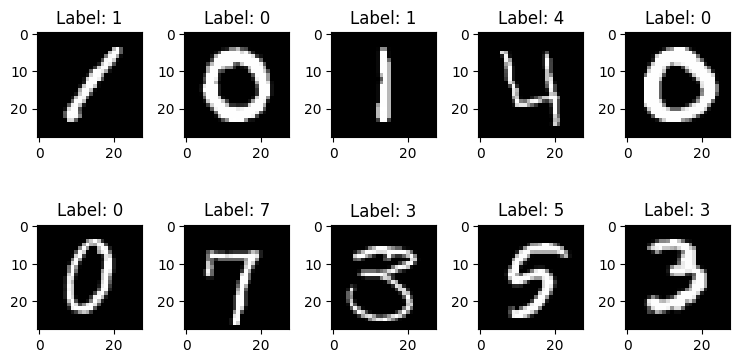

In [21]:
num = 10
images = []
labels = []

for i in range(num):
    xtrain = train.iloc[i, 1:].values.reshape(28, 28, 1)
    ytrain = train.iloc[i, 0]
    images.append(xtrain)
    labels.append(ytrain)


num_row = 2
num_col = 5

# plot images
fig, axes = plt.subplots(num_row, num_col, figsize=(1.5*num_col,2*num_row))
for i in range(num):
    ax = axes[i//num_col, i%num_col]
    ax.imshow(images[i], cmap='gray')
    ax.set_title('Label: {}'.format(labels[i]))
plt.tight_layout()
plt.show()

- ### Basic setting for the model training

In [22]:
batch_size = 64 # suggested default, size of the batches
dataloader = DataLoader( # torch.utils.data.DataLoader
    dataset,
    batch_size=batch_size,
    shuffle=True
)

In [23]:
temp_images, _ = iter(dataloader)._next_data() # We don't use label, so _
print('images shape on batch size = {}'.format(temp_images.size()))

images shape on batch size = torch.Size([64, 1, 28, 28])


In [24]:
# suggested default - beta parameters (decay of first order momentum of gradients)
b1 = 0.5
b2 = 0.999

# suggested default - learning rate
lr = 0.001

In [25]:
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(b1,b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(b1,b2))

In [26]:
Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

- ### Model training

  0%|          | 0/657 [00:00<?, ?it/s]

C:\Users\Heqing\AppData\Local\Temp\ipykernel_42140\686403509.py:7: UserWarning: The torch.cuda.*DtypeTensor constructors are no longer recommended. It's best to use methods such as torch.tensor(data, dtype=*, device='cuda') to create tensors. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\tensor\python_tensor.cpp:80.)
  valid = Variable(Tensor(imgs.size(0), 1).fill_(1.0), requires_grad=False) # imgs.size(0) == batch_size(1 batch) == 64, *TEST_CODE


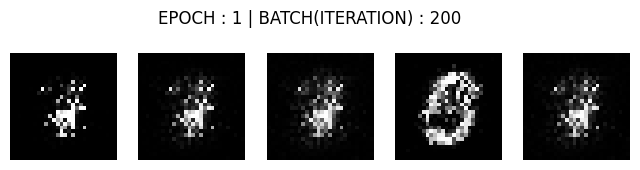

[Epoch: 1/200] [Batch: 200/657] [D loss: 0.542010] [G loss: 1.062084]


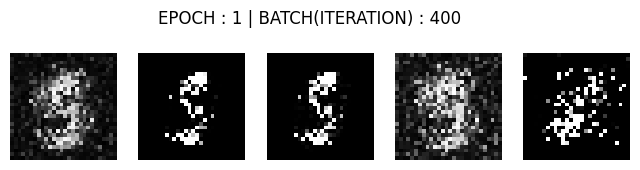

[Epoch: 1/200] [Batch: 400/657] [D loss: 1.150691] [G loss: 0.136328]


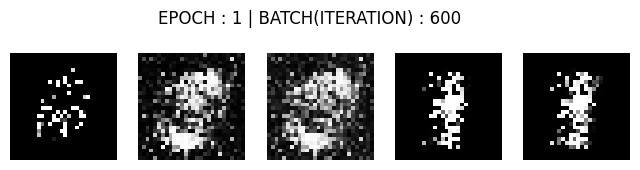

[Epoch: 1/200] [Batch: 600/657] [D loss: 0.416927] [G loss: 0.985166]


  0%|          | 0/657 [00:00<?, ?it/s]

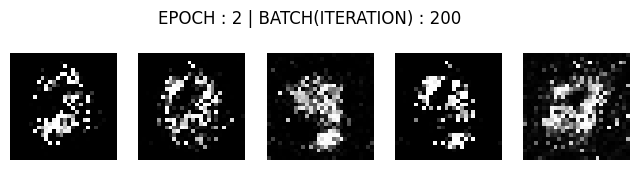

[Epoch: 2/200] [Batch: 200/657] [D loss: 0.564089] [G loss: 0.508194]


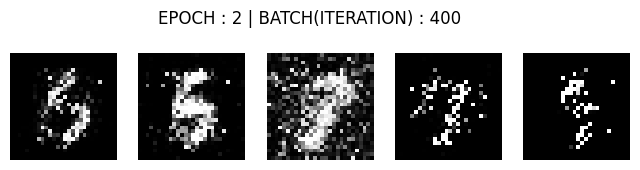

[Epoch: 2/200] [Batch: 400/657] [D loss: 0.385833] [G loss: 1.781612]


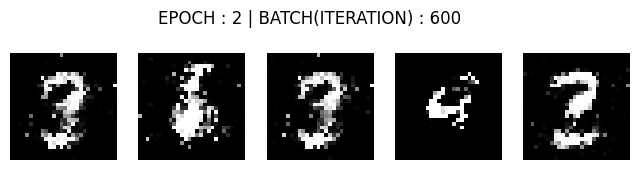

[Epoch: 2/200] [Batch: 600/657] [D loss: 0.498310] [G loss: 0.779966]


  0%|          | 0/657 [00:00<?, ?it/s]

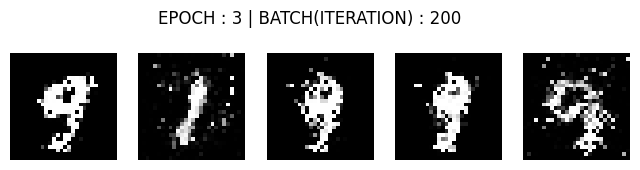

[Epoch: 3/200] [Batch: 200/657] [D loss: 0.411559] [G loss: 1.198376]


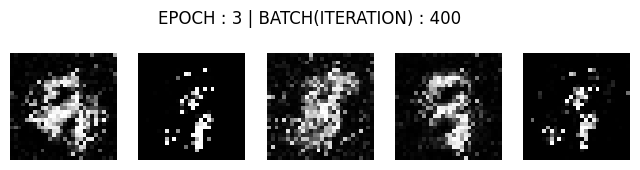

[Epoch: 3/200] [Batch: 400/657] [D loss: 0.454825] [G loss: 1.247444]


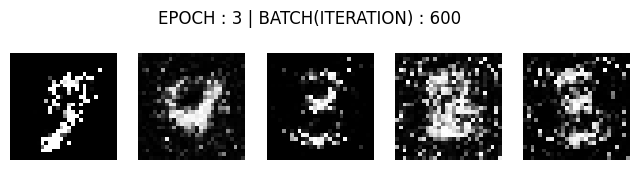

[Epoch: 3/200] [Batch: 600/657] [D loss: 0.496467] [G loss: 1.786937]


  0%|          | 0/657 [00:00<?, ?it/s]

  0%|          | 0/657 [00:00<?, ?it/s]

  0%|          | 0/657 [00:00<?, ?it/s]

  0%|          | 0/657 [00:00<?, ?it/s]

  0%|          | 0/657 [00:00<?, ?it/s]

  0%|          | 0/657 [00:00<?, ?it/s]

  0%|          | 0/657 [00:00<?, ?it/s]

  0%|          | 0/657 [00:00<?, ?it/s]

  0%|          | 0/657 [00:00<?, ?it/s]

  0%|          | 0/657 [00:00<?, ?it/s]

  0%|          | 0/657 [00:00<?, ?it/s]

  0%|          | 0/657 [00:00<?, ?it/s]

  0%|          | 0/657 [00:00<?, ?it/s]

  0%|          | 0/657 [00:00<?, ?it/s]

  0%|          | 0/657 [00:00<?, ?it/s]

  0%|          | 0/657 [00:00<?, ?it/s]

  0%|          | 0/657 [00:00<?, ?it/s]

  0%|          | 0/657 [00:00<?, ?it/s]

  0%|          | 0/657 [00:00<?, ?it/s]

  0%|          | 0/657 [00:00<?, ?it/s]

  0%|          | 0/657 [00:00<?, ?it/s]

  0%|          | 0/657 [00:00<?, ?it/s]

  0%|          | 0/657 [00:00<?, ?it/s]

  0%|          | 0/657 [00:00<?, ?it/s]

  0%|          | 0/657 [00:00<?, ?it/s]

  0%|          | 0/657 [00:00<?, ?it/s]

  0%|          | 0/657 [00:00<?, ?it/s]

  0%|          | 0/657 [00:00<?, ?it/s]

  0%|          | 0/657 [00:00<?, ?it/s]

  0%|          | 0/657 [00:00<?, ?it/s]

  0%|          | 0/657 [00:00<?, ?it/s]

  0%|          | 0/657 [00:00<?, ?it/s]

  0%|          | 0/657 [00:00<?, ?it/s]

  0%|          | 0/657 [00:00<?, ?it/s]

  0%|          | 0/657 [00:00<?, ?it/s]

  0%|          | 0/657 [00:00<?, ?it/s]

  0%|          | 0/657 [00:00<?, ?it/s]

  0%|          | 0/657 [00:00<?, ?it/s]

  0%|          | 0/657 [00:00<?, ?it/s]

  0%|          | 0/657 [00:00<?, ?it/s]

  0%|          | 0/657 [00:00<?, ?it/s]

  0%|          | 0/657 [00:00<?, ?it/s]

  0%|          | 0/657 [00:00<?, ?it/s]

  0%|          | 0/657 [00:00<?, ?it/s]

  0%|          | 0/657 [00:00<?, ?it/s]

  0%|          | 0/657 [00:00<?, ?it/s]

  0%|          | 0/657 [00:00<?, ?it/s]

  0%|          | 0/657 [00:00<?, ?it/s]

  0%|          | 0/657 [00:00<?, ?it/s]

  0%|          | 0/657 [00:00<?, ?it/s]

  0%|          | 0/657 [00:00<?, ?it/s]

  0%|          | 0/657 [00:00<?, ?it/s]

  0%|          | 0/657 [00:00<?, ?it/s]

  0%|          | 0/657 [00:00<?, ?it/s]

  0%|          | 0/657 [00:00<?, ?it/s]

  0%|          | 0/657 [00:00<?, ?it/s]

  0%|          | 0/657 [00:00<?, ?it/s]

  0%|          | 0/657 [00:00<?, ?it/s]

  0%|          | 0/657 [00:00<?, ?it/s]

  0%|          | 0/657 [00:00<?, ?it/s]

  0%|          | 0/657 [00:00<?, ?it/s]

  0%|          | 0/657 [00:00<?, ?it/s]

  0%|          | 0/657 [00:00<?, ?it/s]

  0%|          | 0/657 [00:00<?, ?it/s]

  0%|          | 0/657 [00:00<?, ?it/s]

  0%|          | 0/657 [00:00<?, ?it/s]

  0%|          | 0/657 [00:00<?, ?it/s]

  0%|          | 0/657 [00:00<?, ?it/s]

  0%|          | 0/657 [00:00<?, ?it/s]

  0%|          | 0/657 [00:00<?, ?it/s]

  0%|          | 0/657 [00:00<?, ?it/s]

  0%|          | 0/657 [00:00<?, ?it/s]

  0%|          | 0/657 [00:00<?, ?it/s]

  0%|          | 0/657 [00:00<?, ?it/s]

  0%|          | 0/657 [00:00<?, ?it/s]

  0%|          | 0/657 [00:00<?, ?it/s]

  0%|          | 0/657 [00:00<?, ?it/s]

  0%|          | 0/657 [00:00<?, ?it/s]

  0%|          | 0/657 [00:00<?, ?it/s]

  0%|          | 0/657 [00:00<?, ?it/s]

  0%|          | 0/657 [00:00<?, ?it/s]

  0%|          | 0/657 [00:00<?, ?it/s]

  0%|          | 0/657 [00:00<?, ?it/s]

  0%|          | 0/657 [00:00<?, ?it/s]

  0%|          | 0/657 [00:00<?, ?it/s]

  0%|          | 0/657 [00:00<?, ?it/s]

  0%|          | 0/657 [00:00<?, ?it/s]

  0%|          | 0/657 [00:00<?, ?it/s]

  0%|          | 0/657 [00:00<?, ?it/s]

  0%|          | 0/657 [00:00<?, ?it/s]

  0%|          | 0/657 [00:00<?, ?it/s]

  0%|          | 0/657 [00:00<?, ?it/s]

  0%|          | 0/657 [00:00<?, ?it/s]

  0%|          | 0/657 [00:00<?, ?it/s]

  0%|          | 0/657 [00:00<?, ?it/s]

  0%|          | 0/657 [00:00<?, ?it/s]

  0%|          | 0/657 [00:00<?, ?it/s]

  0%|          | 0/657 [00:00<?, ?it/s]

  0%|          | 0/657 [00:00<?, ?it/s]

  0%|          | 0/657 [00:00<?, ?it/s]

  0%|          | 0/657 [00:00<?, ?it/s]

  0%|          | 0/657 [00:00<?, ?it/s]

  0%|          | 0/657 [00:00<?, ?it/s]

  0%|          | 0/657 [00:00<?, ?it/s]

  0%|          | 0/657 [00:00<?, ?it/s]

  0%|          | 0/657 [00:00<?, ?it/s]

  0%|          | 0/657 [00:00<?, ?it/s]

  0%|          | 0/657 [00:00<?, ?it/s]

  0%|          | 0/657 [00:00<?, ?it/s]

  0%|          | 0/657 [00:00<?, ?it/s]

  0%|          | 0/657 [00:00<?, ?it/s]

  0%|          | 0/657 [00:00<?, ?it/s]

  0%|          | 0/657 [00:00<?, ?it/s]

  0%|          | 0/657 [00:00<?, ?it/s]

  0%|          | 0/657 [00:00<?, ?it/s]

  0%|          | 0/657 [00:00<?, ?it/s]

  0%|          | 0/657 [00:00<?, ?it/s]

  0%|          | 0/657 [00:00<?, ?it/s]

  0%|          | 0/657 [00:00<?, ?it/s]

  0%|          | 0/657 [00:00<?, ?it/s]

  0%|          | 0/657 [00:00<?, ?it/s]

  0%|          | 0/657 [00:00<?, ?it/s]

  0%|          | 0/657 [00:00<?, ?it/s]

  0%|          | 0/657 [00:00<?, ?it/s]

  0%|          | 0/657 [00:00<?, ?it/s]

  0%|          | 0/657 [00:00<?, ?it/s]

  0%|          | 0/657 [00:00<?, ?it/s]

  0%|          | 0/657 [00:00<?, ?it/s]

  0%|          | 0/657 [00:00<?, ?it/s]

  0%|          | 0/657 [00:00<?, ?it/s]

  0%|          | 0/657 [00:00<?, ?it/s]

  0%|          | 0/657 [00:00<?, ?it/s]

  0%|          | 0/657 [00:00<?, ?it/s]

  0%|          | 0/657 [00:00<?, ?it/s]

  0%|          | 0/657 [00:00<?, ?it/s]

  0%|          | 0/657 [00:00<?, ?it/s]

  0%|          | 0/657 [00:00<?, ?it/s]

  0%|          | 0/657 [00:00<?, ?it/s]

  0%|          | 0/657 [00:00<?, ?it/s]

  0%|          | 0/657 [00:00<?, ?it/s]

  0%|          | 0/657 [00:00<?, ?it/s]

  0%|          | 0/657 [00:00<?, ?it/s]

  0%|          | 0/657 [00:00<?, ?it/s]

  0%|          | 0/657 [00:00<?, ?it/s]

  0%|          | 0/657 [00:00<?, ?it/s]

  0%|          | 0/657 [00:00<?, ?it/s]

  0%|          | 0/657 [00:00<?, ?it/s]

  0%|          | 0/657 [00:00<?, ?it/s]

  0%|          | 0/657 [00:00<?, ?it/s]

  0%|          | 0/657 [00:00<?, ?it/s]

  0%|          | 0/657 [00:00<?, ?it/s]

  0%|          | 0/657 [00:00<?, ?it/s]

  0%|          | 0/657 [00:00<?, ?it/s]

  0%|          | 0/657 [00:00<?, ?it/s]

  0%|          | 0/657 [00:00<?, ?it/s]

  0%|          | 0/657 [00:00<?, ?it/s]

  0%|          | 0/657 [00:00<?, ?it/s]

  0%|          | 0/657 [00:00<?, ?it/s]

  0%|          | 0/657 [00:00<?, ?it/s]

  0%|          | 0/657 [00:00<?, ?it/s]

  0%|          | 0/657 [00:00<?, ?it/s]

  0%|          | 0/657 [00:00<?, ?it/s]

  0%|          | 0/657 [00:00<?, ?it/s]

  0%|          | 0/657 [00:00<?, ?it/s]

  0%|          | 0/657 [00:00<?, ?it/s]

  0%|          | 0/657 [00:00<?, ?it/s]

  0%|          | 0/657 [00:00<?, ?it/s]

  0%|          | 0/657 [00:00<?, ?it/s]

  0%|          | 0/657 [00:00<?, ?it/s]

  0%|          | 0/657 [00:00<?, ?it/s]

  0%|          | 0/657 [00:00<?, ?it/s]

  0%|          | 0/657 [00:00<?, ?it/s]

  0%|          | 0/657 [00:00<?, ?it/s]

  0%|          | 0/657 [00:00<?, ?it/s]

  0%|          | 0/657 [00:00<?, ?it/s]

  0%|          | 0/657 [00:00<?, ?it/s]

  0%|          | 0/657 [00:00<?, ?it/s]

  0%|          | 0/657 [00:00<?, ?it/s]

  0%|          | 0/657 [00:00<?, ?it/s]

  0%|          | 0/657 [00:00<?, ?it/s]

  0%|          | 0/657 [00:00<?, ?it/s]

  0%|          | 0/657 [00:00<?, ?it/s]

  0%|          | 0/657 [00:00<?, ?it/s]

  0%|          | 0/657 [00:00<?, ?it/s]

  0%|          | 0/657 [00:00<?, ?it/s]

  0%|          | 0/657 [00:00<?, ?it/s]

  0%|          | 0/657 [00:00<?, ?it/s]

  0%|          | 0/657 [00:00<?, ?it/s]

  0%|          | 0/657 [00:00<?, ?it/s]

  0%|          | 0/657 [00:00<?, ?it/s]

  0%|          | 0/657 [00:00<?, ?it/s]

  0%|          | 0/657 [00:00<?, ?it/s]

  0%|          | 0/657 [00:00<?, ?it/s]

  0%|          | 0/657 [00:00<?, ?it/s]

  0%|          | 0/657 [00:00<?, ?it/s]

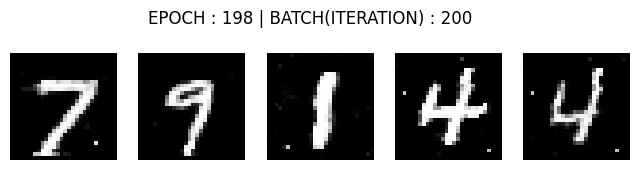

[Epoch: 198/200] [Batch: 200/657] [D loss: 0.494459] [G loss: 1.483593]


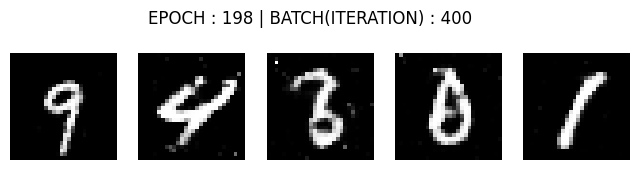

[Epoch: 198/200] [Batch: 400/657] [D loss: 0.488771] [G loss: 1.594568]


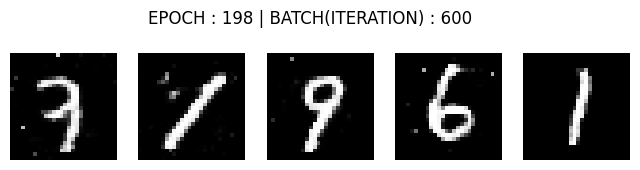

[Epoch: 198/200] [Batch: 600/657] [D loss: 0.478273] [G loss: 1.776111]


  0%|          | 0/657 [00:00<?, ?it/s]

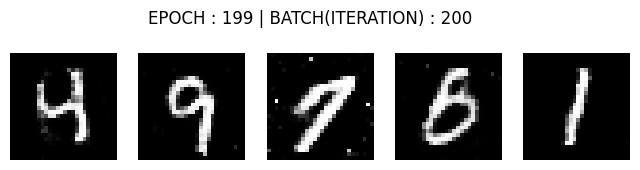

[Epoch: 199/200] [Batch: 200/657] [D loss: 0.421048] [G loss: 1.363702]


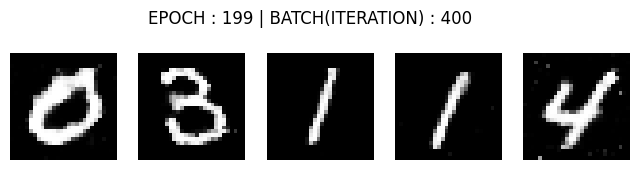

[Epoch: 199/200] [Batch: 400/657] [D loss: 0.396996] [G loss: 1.484724]


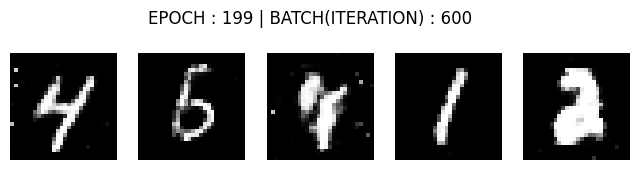

[Epoch: 199/200] [Batch: 600/657] [D loss: 0.530912] [G loss: 2.113133]


  0%|          | 0/657 [00:00<?, ?it/s]

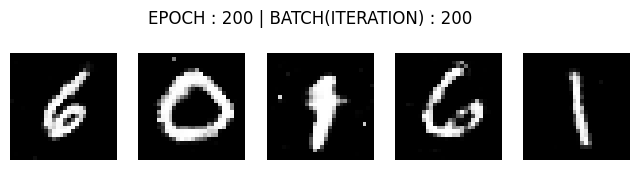

[Epoch: 200/200] [Batch: 200/657] [D loss: 0.534297] [G loss: 1.699507]


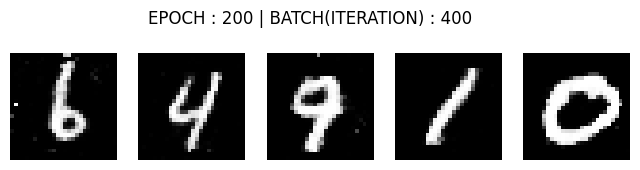

[Epoch: 200/200] [Batch: 400/657] [D loss: 0.435116] [G loss: 1.638625]


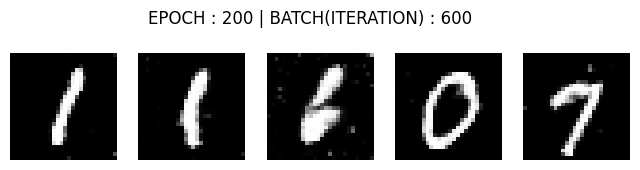

[Epoch: 200/200] [Batch: 600/657] [D loss: 0.616778] [G loss: 0.690409]


In [27]:
n_epochs = 200 # suggested default = 200
for epoch in range(n_epochs):
    for i, (imgs, _) in enumerate(tqdm(dataloader)): # This code(enumerate) is dealt with once more in the *TEST_CODE below.
                                                     # Used 'tqdm' for showing progress 
        
        # Adversarial ground truths (For more detail, refer *Read_More below)
        valid = Variable(Tensor(imgs.size(0), 1).fill_(1.0), requires_grad=False) # imgs.size(0) == batch_size(1 batch) == 64, *TEST_CODE
        fake = Variable(Tensor(imgs.size(0), 1).fill_(0.0), requires_grad=False) # And Variable is for caclulate gradient. In fact, you can use it, but you don't have to. 
                                                                                # requires_grad=False is default in tensor type. *Read_More
        
        # Configure input
        real_imgs = imgs.type(Tensor) # As mentioned, it is no longer necessary to wrap the tensor in a Variable.
      # real_imgs = Variable(imgs.type(Tensor)) # requires_grad=False, Default! It's same.
    
# ------------
# Train Generator
# ------------
        optimizer_G.zero_grad()
        
        # sample noise 'z' as generator input
        z = Tensor(np.random.normal(0, 1, (imgs.shape[0],latent_dim))) # Random sampling Tensor(batch_size, latent_dim) of Gaussian distribution
        # z.shape == torch.Size([64, 100])
        
        # Generate a batch of images
        gen_imgs = generator(z)
        # gen_imgs.shape == torch.Size([64, 1, 28, 28])
        
        # Loss measures generator's ability to fool the discriminator
        g_loss = adversarial_loss(discriminator(gen_imgs), valid) # torch.nn.BCELoss() compare result(64x1) and valid(64x1, filled with 1)
        
        g_loss.backward()
        optimizer_G.step()
        
# ------------
# Train Discriminator
# ------------
        optimizer_D.zero_grad()
        
        # Measure discriminator's ability to classify real from generated samples
        real_loss = adversarial_loss(discriminator(real_imgs), valid) # torch.nn.BCELoss() compare result(64x1) and valid(64x1, filled with 1)
        fake_loss = adversarial_loss(discriminator(gen_imgs.detach()), fake) # We are learning the discriminator now. So have to use detach() 
                                                                             
        d_loss = (real_loss + fake_loss) / 2
        
        d_loss.backward()# If didn't use detach() for gen_imgs, all weights of the generator will be calculated with backward(). 
        optimizer_D.step()
         
    

# ------------
# Real Time Visualization (While Training)
# ------------
        
        sample_z_in_train = Tensor(np.random.normal(0, 1, (imgs.shape[0],latent_dim)))
        # z.shape == torch.Size([64, 100])
        sample_gen_imgs_in_train = generator(sample_z_in_train).detach().cpu()
        # gen_imgs.shape == torch.Size([64, 1, 28, 28])

        if ((epoch+1) <= 3) or ((epoch+1) >= 198):
        
            if ((i+1) % 200) == 0: # show while batch - 200/657, 400/657, 600/657
                nrow=1
                ncols=5
                fig, axes = plt.subplots(nrows=nrow,ncols=ncols, figsize=(8,2))
                plt.suptitle('EPOCH : {} | BATCH(ITERATION) : {}'.format(epoch+1, i+1))
                for ncol in range(ncols):
                    axes[ncol].imshow(sample_gen_imgs_in_train.permute(0,2,3,1)[ncol], cmap='gray')
                    axes[ncol].axis('off')
                plt.show()
                print(
                    "[Epoch: %d/%d] [Batch: %d/%d] [D loss: %f] [G loss: %f]"
                    % (epoch+1, n_epochs, i+1, len(dataloader), d_loss.item(), g_loss.item())
                )